# Ensamble Learning

Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the **wisdom of the crowd**. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an **ensemble** and the technique **Ensemble Learning**.

We can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, we obtain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a **Random Forest**, and despite its simplicity, this is one of the most powerful ML algorithms available today.

## Voting Classifiers
A simple way to create an ensamble is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a **hard voting classifier**. This voting classifier often achieves a higher accuracy than the best classifier in the ensemble. In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy). However, this is only true if all classifiers are **perfectly independent**, making **uncorrelated errors**. One way to get diverse classifiers is to train them using very different algorithms. How is this possible? This is due to the [**law of large numbers**](https://www.youtube.com/watch?v=VpuN8vCQ--M). 

<img src="voting.png" width="400">

The following code trains a voting classifier composed of three diverse classifiers on the moons dataset and check each classifier’s accuracy on the test set:

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), 
                                           ('rf', rnd_clf), 
                                           ('svc', svm_clf)],
                              voting='hard')

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


The voting classifier slightly outperforms all the individual classifiers.

If all classifiers are able to estimate class probabilitie, then you can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting because it gives more weight to highly confident votes. 

All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities:

In [12]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting
Another way to get a diverse set of classifiers is to use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called **bagging**  (short for **bootstrap aggregating**), otherwise it is called **pasting**. The two approaches are similar: in both cases we are sampling the training data to build multiple instances of a classifier, in both cases a training item could be sampled and used to train multiple instances in the collection of classifiers that is produced, however in bagging it is possible for a training sample to be sampled multiple times in the training for the same predictor. Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. 

<img src="bagging.png" width="400"> <img src="pasting.png" width="400">

Scikit-Learn offers a simple API for both bagging and pasting with the **BaggingClassifier** class (or **BaggingRegressor** for regression). 

The following code trains a single Decision Tree and an ensemble of 500 Decision Tree classifiers, both trained on the moons dataset:

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                            n_estimators=500,
                            max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.856
0.904


We can compares the decision boundary of the single tree with the decision boundary of the ensemble. The ensemble generalize much better than the single tree: the decision boundary is less irregular:

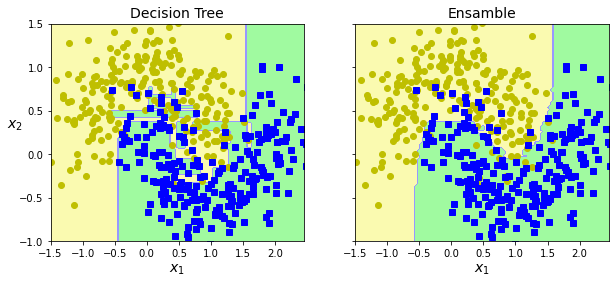

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=1, cmap=custom_cmap)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=14)
    plt.ylabel(r"$x_2$", fontsize=14, rotation=0)
    
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plt.title("Decision Tree", fontsize=14)
plot_decision_boundary(tree_clf, X, y, [-1.5, 2.45, -1, 1.5])

plt.sca(axes[1])
plt.title("Ensamble", fontsize=14)
plot_decision_boundary(bag_clf, X, y, [-1.5, 2.45, -1, 1.5])
plt.ylabel("")

plt.show()

With bagging, some instances may be sampled several times, while others may not be sampled at all. By default the BaggingClassifier samples m training instances with replacement, where m is the size of the training set. This means that only about 63% of the training instances are sampled on average for each predictor. Let's go over how the bootstrap works in order to undestand this value. We have an original sample $x_1, x_2, x_3,...,x_m$. We draw items with replacement from this original set until we have another set of size m. The probability of choosing any one item (say, $x_1$) on the first draw is $1/m$. Therefore, the probability of not choosing that item is $1−1/m$. That's just for the first draw; there are a total of m draws, all of which are independent, so the probability of never choosing this item on any of the draws is $(1−1/m)^m$. Now, let's think about what happens when m gets larger and larger. We can take the limit as m goes towards infinity:

In [15]:
import mpmath as mp
f = lambda x: (1.0 - 1.0/x)**x
mp.limit(f, mp.inf)

mpf('0.36787944117144233')

That's the probability of an item not being chosen. Subtract it from one to find the probability of the item being chosen, which gives you 0.632.

The remaining 37% of the training instances that are not sampled are called **out-of-bag (oob)** instances. Note that they are not the same for all predictors. Since a predictor never sees the oob instances during training, it can be evaluated on
these instances, without the need for a separate validation set. We can evaluate the
ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, we can set **oob_score=True** when creating a BaggingClassifier to
request an automatic oob evaluation after training.

In [37]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500,
                            bootstrap=True,
                            oob_score=True)
bag_clf.fit(X_train, y_train)
print(bag_clf.oob_score_)

y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.896
0.896


The oob decision function for each training instance is also available through the
**oob_decision_function_** variable.

The BaggingClassifier class supports sampling the features as well. Sampling is
controlled by two hyperparameters: **max_features** and **bootstrap_features**. They
work the same way as max_samples and bootstrap, but for feature sampling instead of
instance sampling. Thus, each predictor will be trained on a random subset of the input
features. This technique is particularly useful when you are dealing with high-dimensional inputs(such as images). Sampling both training instances and features is called the **Random Patches method**. Keeping all training instances, but sampling features is called the **Random Subspaces method**. Sampling features results in even more predictor diversity, trading a bit more bias for a lower variance.

## Random Forests
A Random Forest is an ensemble of Decision Trees, generally trained via the bagging method, typically with max_samples set to the size of the training set. 

<img src="random-forest.png" width="500">

Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, you can instead use the **RandomForestClassifier** class, which is more convenient and optimized for Decision Trees (similarly, there is a **RandomForestRegressor** class for regression tasks). The RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

In [48]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.92


The Random Forest algorithm introduces **extra randomness** when growing trees. Instead
of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model. 

The following BaggingClassifier is roughly equivalent to the previous RandomForestClassifier, we can compare the accuracy.

In [49]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


It is possible to make trees even more random by using **random thresholds** for each feature rather than searching for the best possible thresholds. A forest of such extremely random trees is called an **Extremely Randomized Trees ensemble** (or **Extra-Trees** for short). Once again, this technique trades more bias for a lower variance. It also makes it much faster to train than regular Random Forests, because finding the best possible threshold for each feature at every node is one of the most time-consuming tasks of growing a tree.

We can create an Extra-Trees classifier using Scikit-Learn’s **ExtraTreesClassifier**
class.

In [50]:
from sklearn.ensemble import ExtraTreesClassifier
extra_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
extra_clf.fit(X_train, y_train)
y_pred_rf = extra_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))

0.92


A great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest).

Scikit-Learn computes this score automatically for each feature after training, then it
scales the results so that the sum of all importances is equal to 1. You can access the
result using the **feature_importances_** variable. 

We can try this measure on the iris datase, as an example:

In [51]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(iris["data"], iris["target"])

for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10200681995865356
sepal width (cm) 0.023851753439868728
petal length (cm) 0.41939593169782274
petal width (cm) 0.45474549490365496


It seems that the most important features are the petal length and width (42%), while sepal length and width are rather unimportant in comparison.

We can try also to find the most important pixels on the MNIST datase:

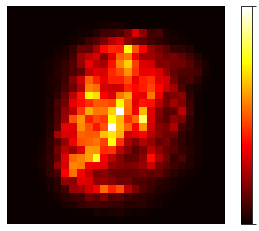

In [53]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.hot, interpolation="nearest")
    plt.axis("off")
    
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])

plt.show()

Random Forests are very handy to get **a quick understanding of what features actually
matter**, in particular if you need to perform feature selection.

## Boosting

